# **MixupVI**

#### Standard imports

In [1]:
import scanpy as sc
import scvi
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from loguru import logger

sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

/home/owkin/deepdeconv/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/owkin/deepdeconv/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data preparation and model training

### 1.1 Loading and preparing data 

#### Cross-tissue immune cell analysis reveals tissue-specific features in humans - Global

Despite their crucial role in health and disease, our knowledge of immune cells within human tissues remains limited. We surveyed the immune compartment of 16 tissues from 12 adult donors by single-cell RNA sequencing and VDJ sequencing generating a dataset of ~360,000 cells. To systematically resolve immune cell heterogeneity across tissues, we developed CellTypist, a machine learning tool for rapid and precise cell type annotation. Using this approach, combined with detailed curation, we determined the tissue distribution of finely phenotyped immune cell types, revealing hitherto unappreciated tissue-specific features and clonal architecture of T and B cells. Our multitissue approach lays the foundation for identifying highly resolved immune cell types by leveraging a common reference dataset, tissue-integrated expression analysis, and antigen receptor sequencing.

```{important}
All scvi-tools models require AnnData objects as input.
```

In [11]:
adata_raw = sc.read_h5ad("/home/owkin/data/cross-tissue/omics/raw/local.h5ad")

In [16]:
logger.info("Check if AnnData object contains raw counts")

print(np.unique(adata_raw.X[0].toarray()))
print(np.unique(adata_raw.X[0].toarray()).dtype)

2023-11-17 11:33:23.062 | INFO     | __main__:<module>:1 - Check if AnnData object contains raw counts


[0.         0.92765963 1.4004854  1.7202194  1.9621122  2.1567407
 2.3195903  2.4595966  2.582387   2.6917353  2.7902963  2.8800087
 2.9623313  3.0383892  3.109069   3.1750815  3.2370045  3.2953157
 3.3504136  3.4026332  3.4522607  3.4995415  3.5446875  3.5878828
 3.6292894  3.6690495  3.7441196  3.779642   3.8139458  3.847112
 3.8792129  3.9103155  3.94048    3.9697611  3.998209   4.0258703
 4.052787   4.129444   4.153744   4.267105   4.288313   4.30908
 4.3294253  4.3689137  4.388088   4.406902   4.4434996  4.4613085
 4.6678853  4.7100534  4.7237234  4.737209   4.776608   4.9203024
 5.289213  ]
float32


In [13]:
adata_raw.X.

<329762x36503 sparse matrix of type '<class 'numpy.float32'>'
	with 637063447 stored elements in Compressed Sparse Row format>

In [2]:
from benchmark_utils import (
  preprocess_scrna,
  add_cell_types_grouped,
)

In [3]:
SIGNATURE_CHOICE = "crosstissue_general"  # ["laughney", "crosstissue_general", "crosstissue_granular_updated"]
CELL_TYPE_GROUP = "primary_groups" #"updated_granular_groups" 

## CTI 
adata = sc.read("/home/owkin/deepdeconv/data/cti_adata.h5ad")

adata

AnnData object with n_obs × n_vars = 329762 × 36503
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'development_stage_ontology_term_id_colors', 'schema_version', 'sex_ontology_term_id_colors', 'title'
    obsm: 'X_umap'

In [4]:
logger.info("Check if AnnData object contains raw counts")

print(np.unique(adata.X[0].toarray()))
print(np.unique(adata.X[0].toarray()).dtype)

2023-11-17 11:01:15.166 | INFO     | __main__:<module>:1 - Check if AnnData object contains raw counts


[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  40.  41.  46.  47.  48.
  49.  51.  52.  53.  55.  56.  69.  72.  73.  74.  77.  89. 129.]
float32


In [5]:
# preprocessing
preprocess_scrna(adata=adata,
                 keep_genes=2500,
                 batch_key="donor_id")

In [6]:
print(np.unique(adata.X[0].toarray()))
print(np.unique(adata.X[0].toarray()).dtype)

[0.         0.92765963 1.4004854  1.7202194  1.9621122  2.1567407
 2.3195903  2.4595966  2.582387   2.6917353  2.7902963  2.9623313
 3.0383892  3.109069   3.2370045  3.4026332  3.4522607  3.7441196
 3.879213   3.9697611  4.3294253  4.3689137  4.388088   4.406902
 4.4434996  4.6678853  4.7237234  4.9203024 ]
float32


In [7]:
print(np.unique(adata.raw.X[0].toarray()))
print(np.unique(adata.raw.X[0].toarray()).dtype)

[0.         0.92765963 1.4004854  1.7202194  1.9621122  2.1567407
 2.3195903  2.4595966  2.582387   2.6917353  2.7902963  2.880009
 2.9623313  3.0383892  3.109069   3.1750815  3.2370045  3.2953157
 3.3504136  3.4026332  3.4522607  3.4995415  3.5446875  3.5878828
 3.6292894  3.6690495  3.7441196  3.779642   3.8139458  3.847112
 3.879213   3.9103155  3.94048    3.9697611  3.998209   4.0258703
 4.052787   4.129444   4.153744   4.267105   4.288313   4.30908
 4.3294253  4.3689137  4.388088   4.406902   4.4434996  4.4613085
 4.6678853  4.7100534  4.7237234  4.737209   4.776608   4.9203024
 5.289213  ]
float32


In [8]:
print(np.unique(adata.layers["counts"][0].toarray()))
print(np.unique(adata.layers["counts"][0].toarray()).dtype)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 12. 13. 14. 16. 19. 20. 27.
 31. 34. 49. 51. 52. 53. 55. 69. 73. 89.]
float32


### Load pre-processed data

In [ ]:
# adata = ad.read_h5ad("/home/owkin/cti_data/processed/cti_processed.h5ad")

# adata.X.shape, adata.raw.X.shape

### Signature

In [9]:
from benchmark_utils import(
  split_dataset,
  create_signature,
)

signature = create_signature(adata, group=CELL_TYPE_GROUP)

signature.head()

,TNK,B,MonoMacro,DC,Mast
Genes,,,,,
ENSG00000112149,0.265365,1.547031,0.757346,1.124696,0.95805
ENSG00000134539,0.730107,0.006398,0.010922,0.01334,0.022415
ENSG00000167641,0.001189,0.045093,0.003123,0.545117,0.000696
ENSG00000041353,0.040955,0.000856,0.002051,0.002891,0.873171
ENSG00000173369,0.099665,0.066843,1.808693,0.415868,0.074043


In [20]:
adata = add_cell_types_grouped(adata,
                               group=CELL_TYPE_GROUP)

In [49]:
adata = add_cell_types_grouped(adata,
                               group="updated_granular_groups")

In [50]:
adata.obs["updated_granular_groups"].value_counts()

updated_granular_groups
CD4T      88874
CD8T      60606
B         44808
NK        29493
Mono      24267
Tregs     12143
Plasma     7980
Mast       3291
DC         2478
Name: count, dtype: int64

In [22]:
adata.obs[CELL_TYPE_GROUP].value_counts()

primary_groups
TNK          216611
B             52788
MonoMacro     45844
Mast           3291
DC             2478
Name: count, dtype: int64

Train scVI

In [24]:
adata = adata.copy()
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["assay", "donor_id"],
    # continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

model = scvi.model.SCVI(adata)
model.train(max_epochs=300)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 300/300: 100%|██████████| 300/300 [1:52:31<00:00, 21.89s/it, v_num=1, train_loss_step=655, train_loss_epoch=615]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [1:52:31<00:00, 22.50s/it, v_num=1, train_loss_step=655, train_loss_epoch=615]


In [28]:
model.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

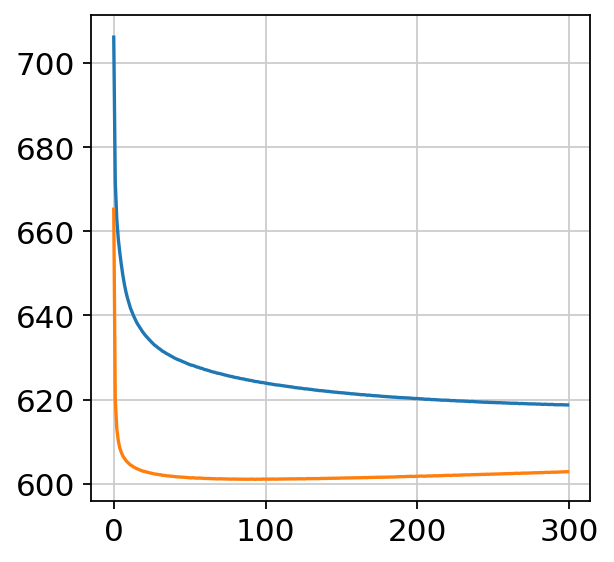

In [35]:
plt.plot(model.history["elbo_train"])
plt.plot(model.history["reconstruction_loss_train"])

In [36]:
scvi_latent = model.get_latent_representation()

scvi_latent.shape

(321012, 10)

In [41]:
adata.obsm["scvi_latent"] = scvi_latent

In [42]:
model.save("models/scvi_donor_assay/")

### Batch effects exploration

In [31]:
# # PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

In [32]:
# # UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'updated_granular_groups' as categorical
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


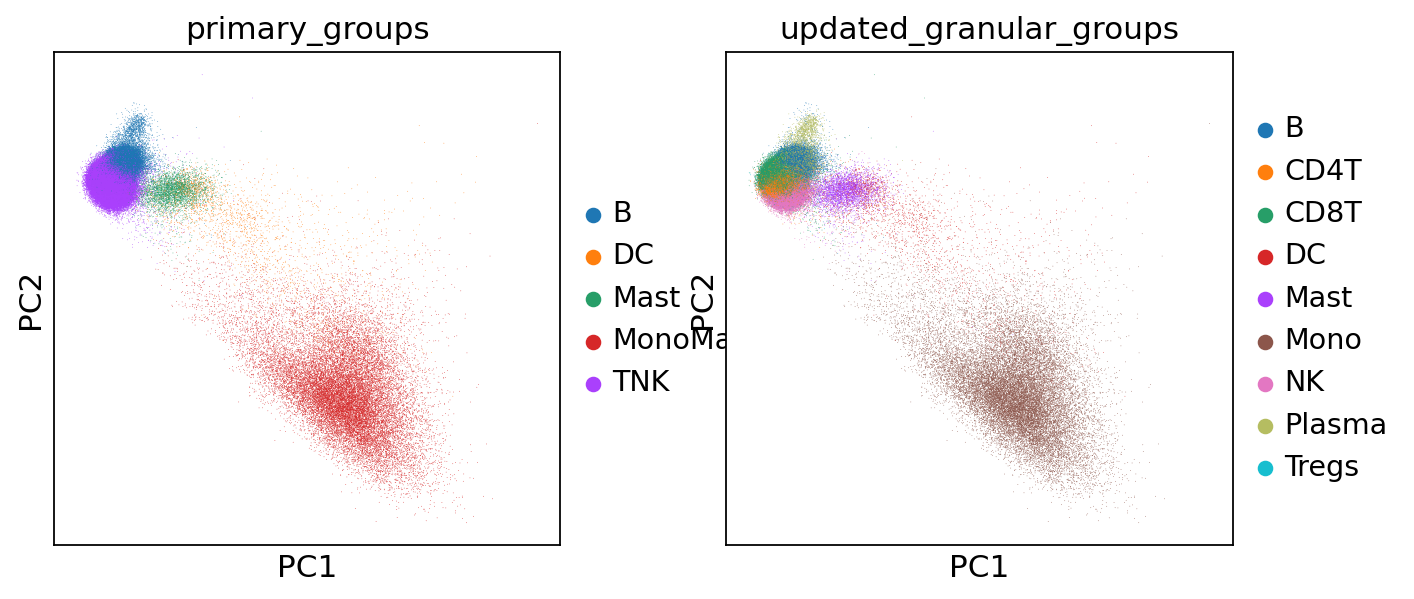

In [51]:
sc.pl.pca(adata,
          color=["primary_groups", "updated_granular_groups"])

/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


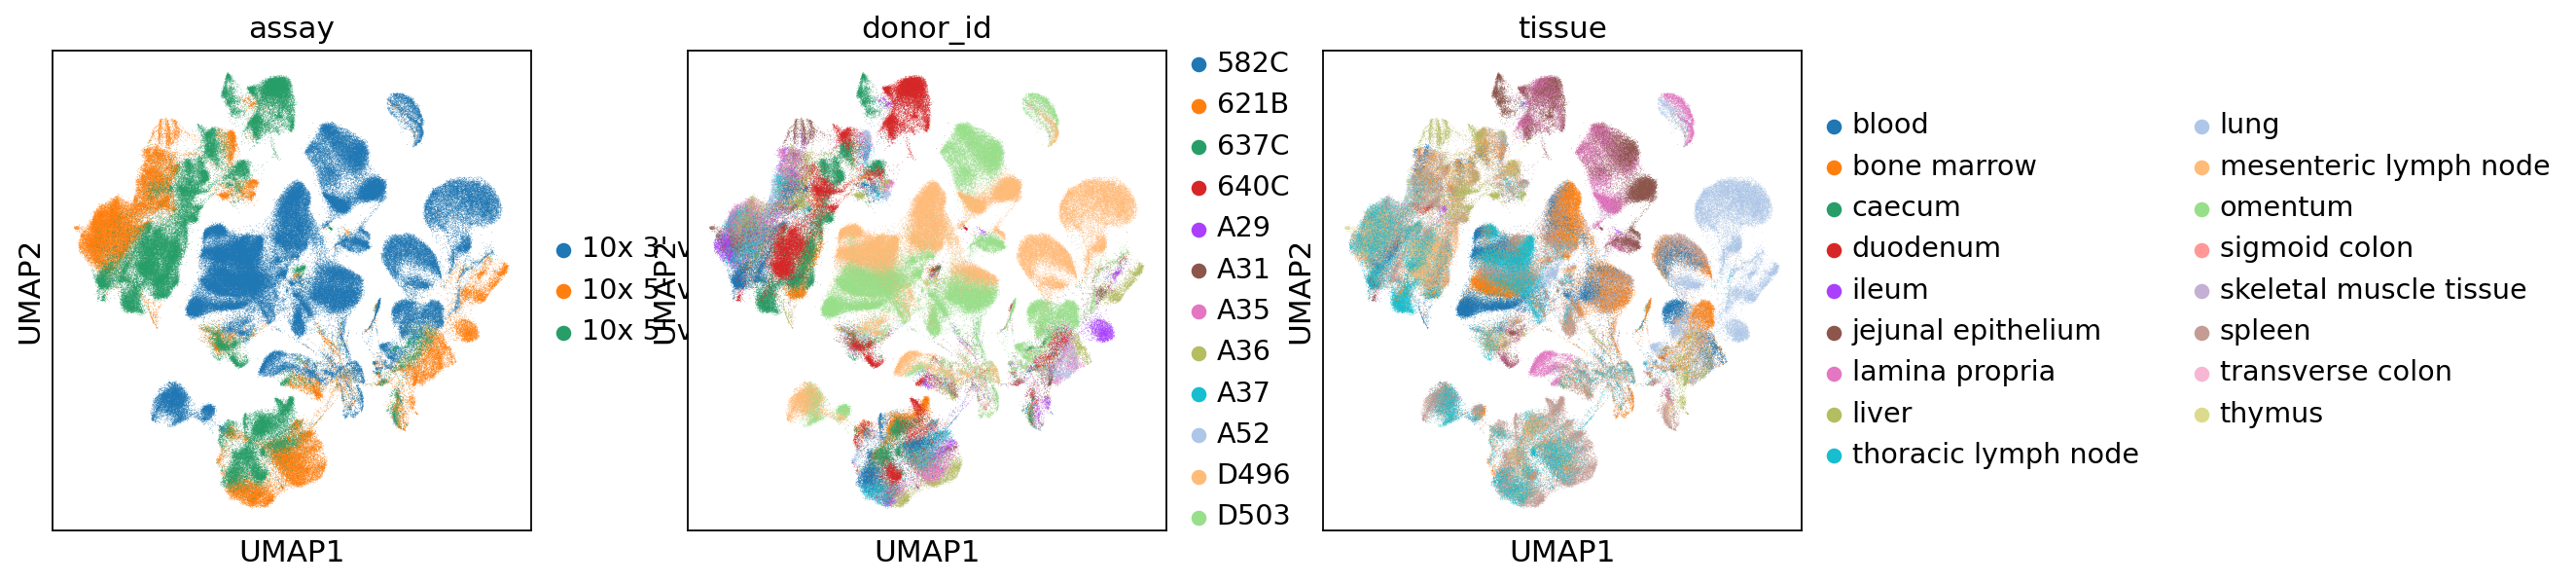

In [40]:
sc.pl.umap(adata,
          color=["assay", "donor_id", "tissue"]
          )

In [43]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="scvi_latent")
sc.tl.umap(adata, min_dist=0.3)

/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


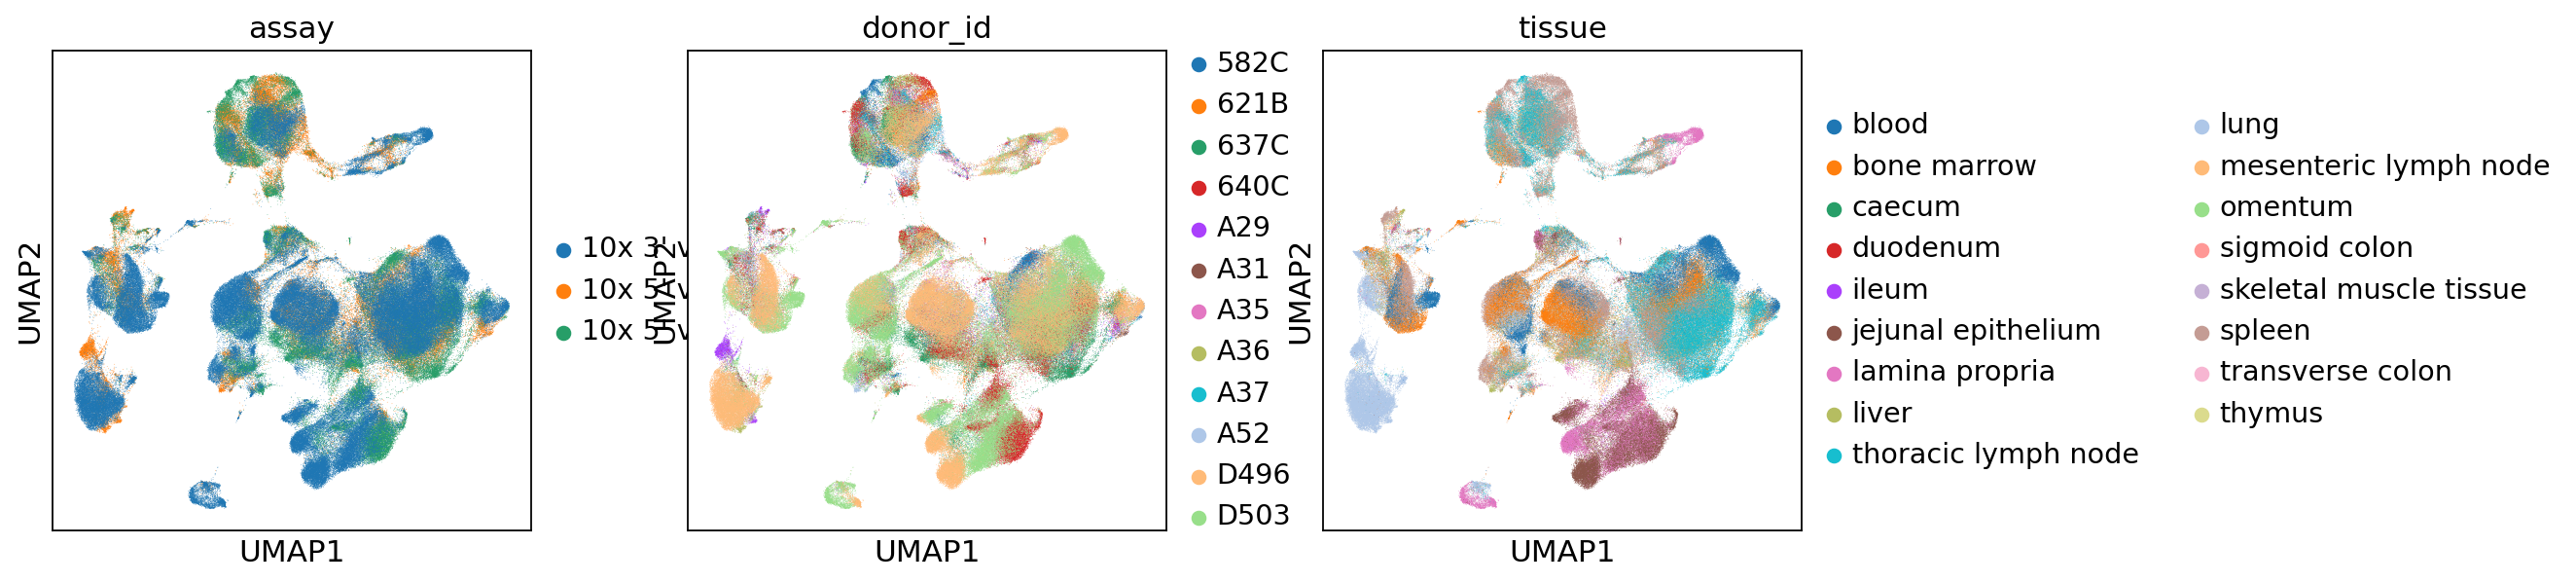

In [45]:
sc.pl.umap(adata,
          color=["assay", "donor_id", "tissue"]
          )

/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


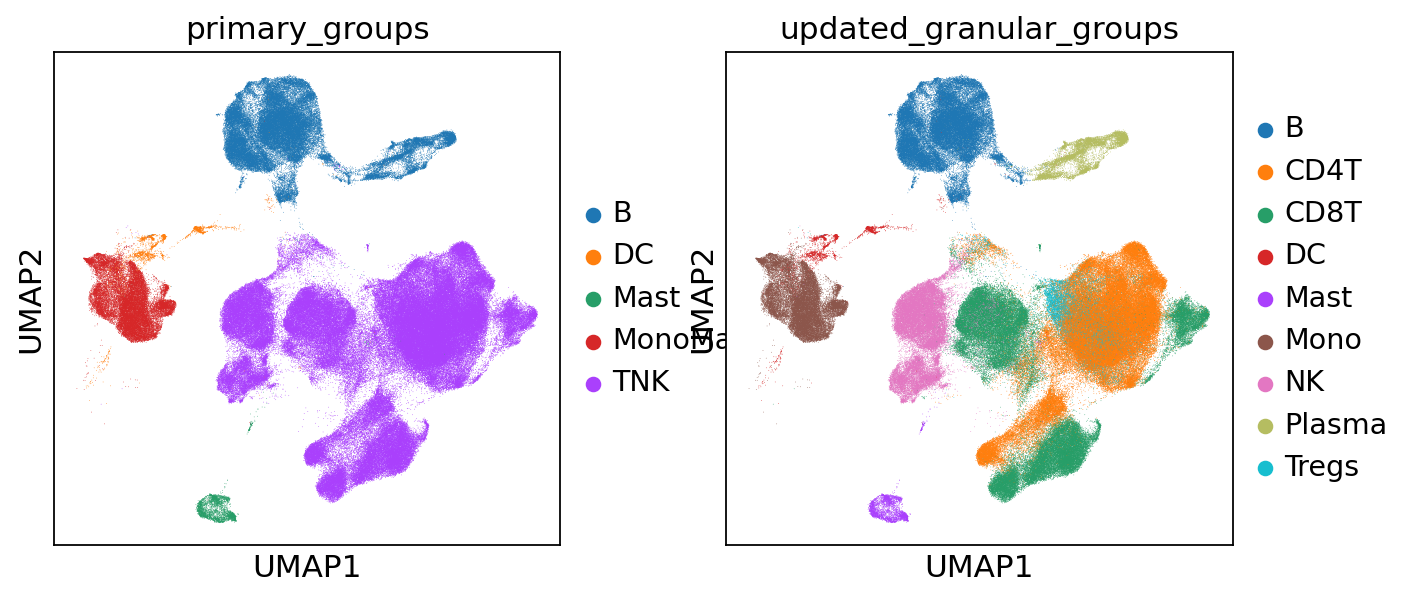

In [53]:
sc.pl.umap(adata,
          color=["primary_groups", "updated_granular_groups"]
          )

### MixupVI

In [44]:
MODEL_SAVE = False
MAX_EPOCHS = 2
BATCH_SIZE = 1024
TRAIN_SIZE = 1.0
CONT_COV = None  # list of continuous covariates to include
ENCODE_COVARIATES = False  # should be always False for now, we don't encode cat covar
ENCODE_CONT_COVARIATES = False  # True or False, whether to include cont covar
SIGNATURE_TYPE = "pre_encoded"  # ["pre_encoded", "post_inference"]
USE_BATCH_NORM = "none"  # ["encoder", "decoder", "none", "both"]
LOSS_COMPUTATION = "latent_space"  # ["latent_space", "reconstructed_space"]
PSEUDO_BULK = "pre_encoded"  # ["pre_encoded", "post_inference"]
MIXUP_PENALTY = "l2"  # ["l2", "kl"]
DISPERSION = "gene"  # ["gene", "gene_cell"]
GENE_LIKELIHOOD = "zinb"  # ["zinb", "nb", "poisson"]

In [ ]:
from benchmark_utils import (
    run_categorical_value_checks,
    run_incompatible_value_checks,
)

CAT_COV = [CELL_TYPE_GROUP]
run_categorical_value_checks(
    cell_group=CELL_TYPE_GROUP, # cell_type_group,
    cat_cov=CAT_COV, # for now, only works with cell groups as categorical covariate
    cont_cov=CONT_COV,
    encode_covariates=ENCODE_COVARIATES,
    encode_cont_covariates=ENCODE_CONT_COVARIATES,
    use_batch_norm=USE_BATCH_NORM,
    signature_type=SIGNATURE_TYPE,
    loss_computation=LOSS_COMPUTATION,
    pseudo_bulk=PSEUDO_BULK,
    mixup_penalty=MIXUP_PENALTY,
    dispersion=DISPERSION,
    gene_likelihood=GENE_LIKELIHOOD,
)
run_incompatible_value_checks(
    pseudo_bulk=PSEUDO_BULK,
    loss_computation=LOSS_COMPUTATION,
    use_batch_norm=USE_BATCH_NORM,
    mixup_penalty=MIXUP_PENALTY,
    gene_likelihood=GENE_LIKELIHOOD,
)

# 3. Visualizations 

#### Latent space

In [ ]:
# Regular scVI
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

latent.shape

### 2D Embedding plots

UMAP on PCA (Without scVI - no batch correction)

In [ ]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

In [ ]:
sc.pl.umap(
    adata,
    color=["cell_types_grouped", "cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor_id", "assay"],
    ncols=2,
    frameon=False,
)

UMAP on scVI latent spae

In [ ]:
# run PCA then generate UMAP plots
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

In [ ]:
sc.pl.umap(
    adata,
    color=["cell_types_grouped", "cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor_id", "assay"],
    ncols=2,
    frameon=False,
)

The `model.get...()` functions default to using the anndata that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

We will use it to compute the **mean gene expression vector for each cell type present in the dataset** .

# 4. Building a signature matrix

### Denoised signature matrix (skip)

In [ ]:
# Denoised signature matrix computation

# df_signature_denoised = pd.DataFrame()

# for cell_type in adata.obs["cell_types_grouped"].unique():
#     indices = adata[adata.obs.cell_types_grouped == cell_type].obs.index
#     integer_indices = adata.obs.index.get_indexer(indices)
#     # latent_subset = model.get_latent_representation(adata_subset)
#     denoised = model.get_normalized_expression(indices=integer_indices,
#                                                library_size=1e4)
#     df = denoised.mean(axis=0).to_frame()
#     df.columns = [cell_type]
#     df_signature_denoised = pd.concat([df_signature_denoised, df], axis=1)


# df_signature_denoised.drop(["To remove"], axis=1, inplace=True)

# keep_genes = list(set(signature.index) & set(df_signature_denoised.index))

# signature = signature.loc[keep_genes]
# df_signature_denoised = df_signature_denoised.loc[keep_genes]

# df_signature_denoised.to_csv("/home/owkin/project/Almudena/Output/Crosstiss_Immune/signature_cti_csv_5000.csv")

###### Vanilla signature matrix
# X_norm = sc.pp.normalize_total(adata,
#                                target_sum=1e4,
#                                layer="counts",
#                                inplace=False)['X']

# df_signature = pd.DataFrame()

# for cell_type in adata.obs["cell_type"].unique():
#     indices = adata[adata.obs.cell_type == cell_type].obs.index
#     integer_indices = adata.obs.index.get_indexer(indices)
#     df = pd.DataFrame(X_norm[integer_indices, :].mean(axis=0).T,
#              index=adata.var_names,
#              columns=[cell_type])
#     df_signature = pd.concat([df_signature, df], axis=1) 

Correlation between signature matrices

In [ ]:
# import seaborn as sns 
# from scipy.stats import spearmanr, pearsonr
# import numpy as np

# cell_types = list(signature.columns)

# n_cols = 5

# fig, ax = plt.subplots(1, n_cols, figsize=(25, 5))

# for i in range(n_cols):
#     cell_type = cell_types[i]
#     x_sig = signature[cell_type].values
#     x_denoised = df_signature_denoised[cell_type].values
#     # keep_genes = pd.Index(list(set(marker_genes[cell_type]) & set(adata.var_names)))
#     # x_raw = df_signature.loc[keep_genes][cell_type].values
#     # x_denoised = df_signature_denoised.loc[keep_genes][cell_type].values
#     corr = spearmanr(x_sig, x_denoised)[0]
    
#     sns.scatterplot(x=x_sig,
#                     y=x_denoised,
#                     ax=ax[i]
#                     )
#     ax[i].set_xlabel(f"Denoised average ({cell_type})")
#     ax[i].set_ylabel(f"Signature average ({cell_type})")
#     ax[i].set_title(f"Correlation {np.around(corr,3)}")

### Denoised dataset

In [ ]:
denoised_train = model.get_normalized_expression(
                                            adata_train,
                                            library_size=1e4)

denoised_train

In [ ]:
denoised_test = model.get_normalized_expression(
                                            adata_test,
                                            library_size=1e4)

denoised_test

In [ ]:
len(set(denoised_train.index) & set(denoised_test.index))

Save denoised datasets

In [ ]:
denoised_train.to_csv("/home/owkin/project/Almudena/Output/Crosstiss_Immune/denoised_train_cti_5000.csv")
denoised_test.to_csv("/home/owkin/project/Almudena/Output/Crosstiss_Immune/denoised_test_cti_5000.csv")

# 5. Latent space linearity sanity checks

In [ ]:
import tqdm
from scvi_sanity_checks_utils import sanity_checks_metrics

In [ ]:
batch_size = [128, 256, 512, 1024, 2048, 4096, 8192, 16384] #, 32768, 65536, 131072] 

latent_space_metrics = {}

params = [str(x) for x in (100, 200, 300, 400)]

for param in tqdm.tqdm(params[:1]):
    latent_space_metrics[param] = {}
    metrics, errors = sanity_checks_metrics(models[param],
                                            adata,
                                            batch_sizes=batch_size,
                                            n_repeats=100,
                                            use_get_latent=True)
    latent_space_metrics[param]["corr"] = metrics["corr"]
    latent_space_metrics[param]["error"] = errors["corr"]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

plt.plot(batch_size, corrs, color="green", linestyle="--", marker="+")
plt.xlabel("Batch size")
plt.ylabel("Pearson correaltion")
plt.xticks(batch_size)
plt.title("Sanity check 0: correlation between sum(encodings)~=encoder(pseudo-bulk)")